In [1]:
from june.records import RecordReader
import matplotlib.pyplot as plt
import pandas as pd

No --data argument given - defaulting to:
/cosma6/data/dp004/dc-cues1/JUNE-private/data
No --configs argument given - defaulting to:
/cosma6/data/dp004/dc-cues1/JUNE-private/june/configs
--------------------------------------------------------------------------
By default, for Open MPI 4.0 and later, infiniband ports on a device
are not used by default.  The intent is to use UCX for these devices.
You can override this policy by setting the btl_openib_allow_ib MCA parameter
to true.

  Local host:              login7b
  Local adapter:           mlx5_0
  Local port:              1

--------------------------------------------------------------------------
--------------------------------------------------------------------------

  Local host:   login7b
  Local device: mlx5_0
--------------------------------------------------------------------------


In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [3]:
plt.style.use(['science','no-latex'])
plt.style.reload_library()

In [4]:
n_runs = 8 

In [5]:
def read_df(root='infections', run=0,):
    run_str= str(run).zfill(3)
    df = pd.read_csv(
        f'/cosma5/data/durham/covid19/arnau/runs/olympia/results/run_{run_str}/{root}_df_{run_str}.csv'
    )
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    if root == 'infections':
        return df[df['location_specs'] != 'infection_seed']
    else:
        return df


In [6]:
%%time

# read one people df
read = RecordReader(
    results_path='/cosma5/data/durham/covid19/arnau/runs/olympia/results/run_001/'
)
people_df = read.table_to_df('population')

CPU times: user 2min 11s, sys: 30.3 s, total: 2min 41s
Wall time: 3min 16s


In [7]:
people_df.head(2)

,age,primary_activity_id,residence_id,area_id,sex,ethnicity,primary_activity_type,residence_type,vaccine_type
id,,,,,,,,,
9948516,0,0,4013224,30695,f,A1,None,household,none
9948517,0,0,4013219,30695,f,A1,None,household,none


In [8]:
%%time


infections_dfs = [read_df(run=run) for run in range(n_runs)]


CPU times: user 5min 2s, sys: 49.8 s, total: 5min 51s
Wall time: 5min 55s


In [9]:
%%time


deaths_dfs = [read_df(root='deaths',run=run) for run in range(n_runs)]



CPU times: user 311 ms, sys: 33.4 ms, total: 344 ms
Wall time: 835 ms


Text(0, 0.5, 'Daily Infections')

2021-08-19 18:35:28,070 - matplotlib.font_manager - WARNING - findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


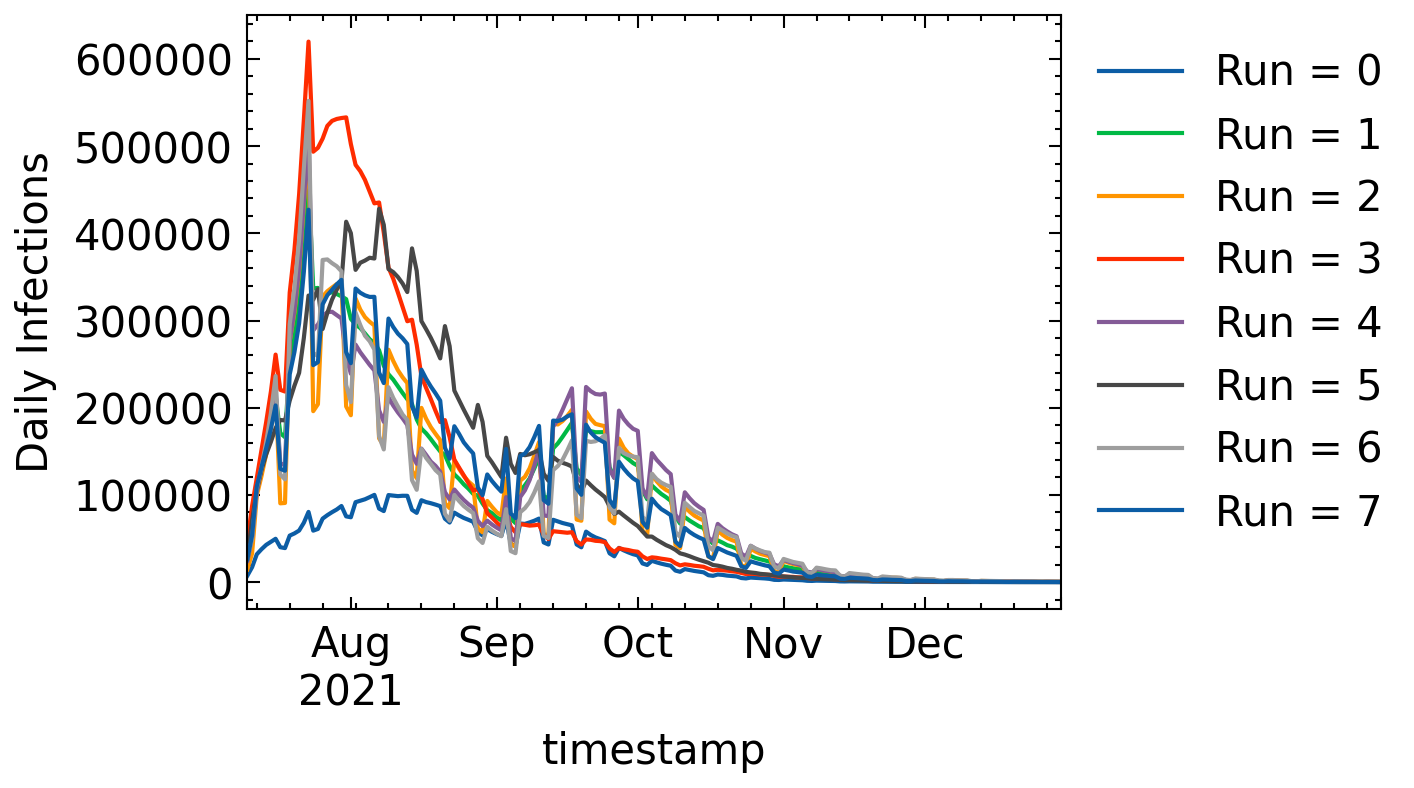

In [10]:
for run, df in enumerate(infections_dfs):
    df.groupby('timestamp').size().plot(label=f'Run = {run}')
plt.legend()
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('Daily Infections')

Text(0, 0.5, 'Cumulative daily infections')

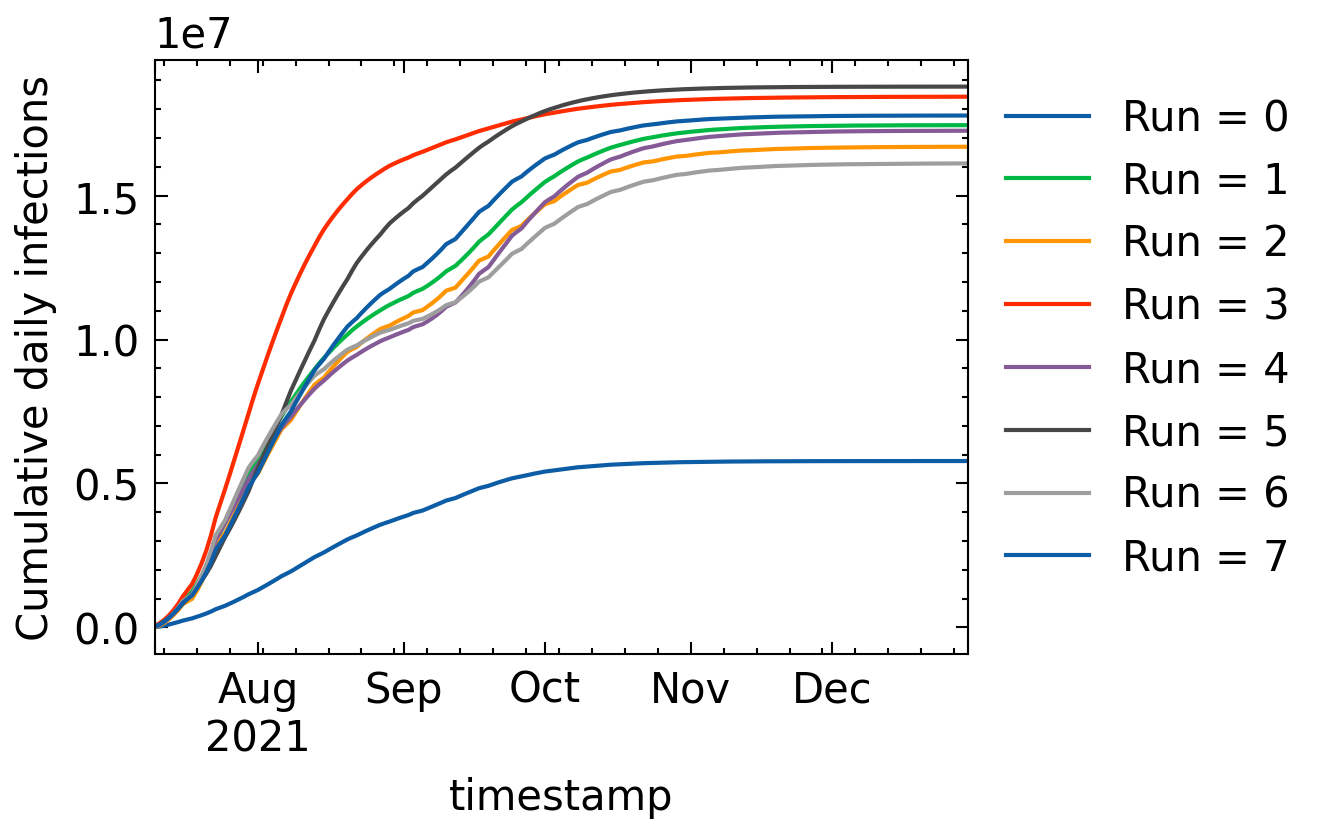

In [11]:
for run, df in enumerate(infections_dfs):
    df.groupby('timestamp').size().cumsum().plot(label=f'Run = {run}')
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('Cumulative daily infections')

In [23]:
[deaths_dfs[i].groupby('timestamp').size().loc['2021-08-19'] for i in range(len(deaths_dfs))]

[338, 286, 424, 550, 361, 535, 368, 474]

Text(0, 0.5, 'Daily deaths')

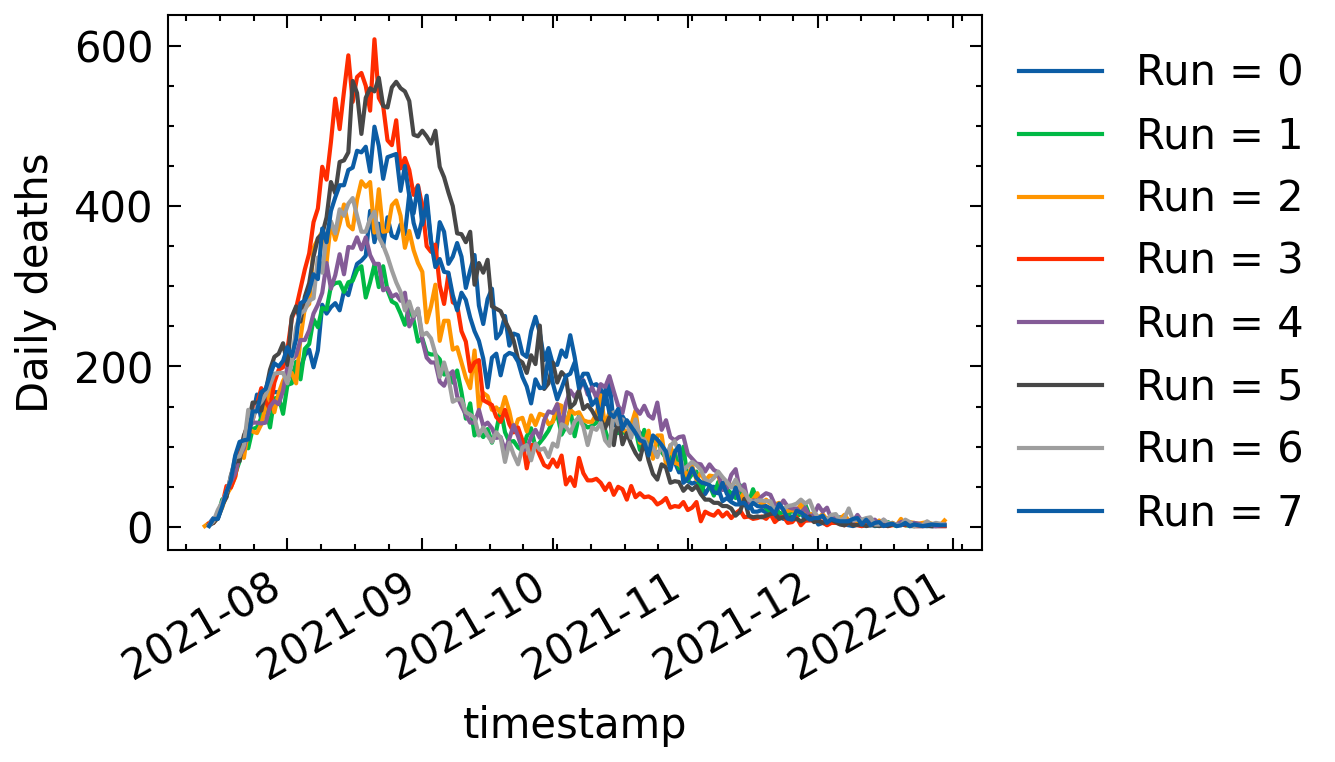

In [12]:
for run, df in enumerate(deaths_dfs):
    df.groupby('timestamp').size().plot(label=f'Run = {run}')
plt.legend()
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('Daily deaths')

Text(0, 0.5, 'Cumulative deaths')

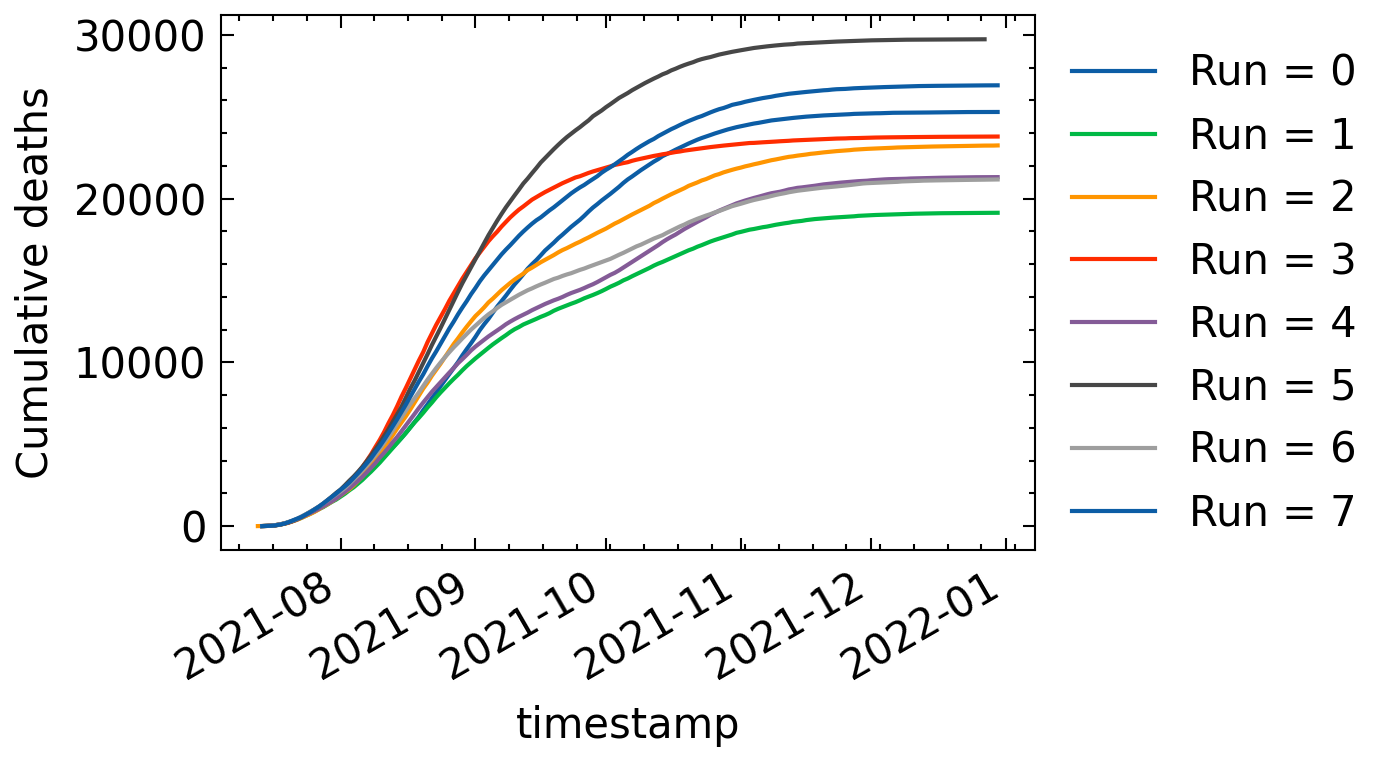

In [13]:
for run, df in enumerate(deaths_dfs):
    df.groupby('timestamp').size().cumsum().plot(label=f'Run = {run}')
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('Cumulative deaths')

In [14]:
# Do children get herd immunity before schools reopen? Let's check with Run=2

infections_df = infections_dfs[2]

age_bins = (0,12,18,25,35,45,55,65,75,150)

infected_by_age = infections_df.groupby([pd.cut(infections_df['age'],
            bins=age_bins), 'timestamp']).size()
n_by_age = people_df.groupby(pd.cut(people_df['age'],
            bins=age_bins)).size()


Text(0.5, 0, '')

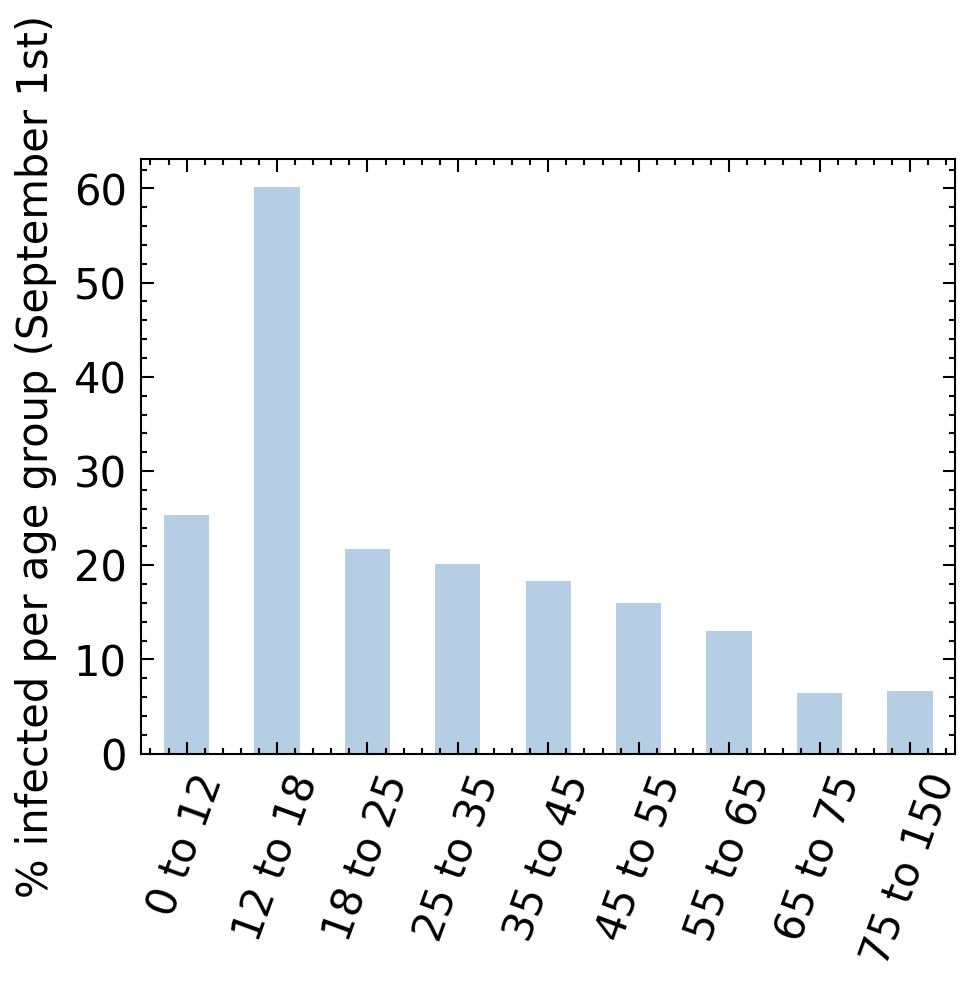

In [15]:
infected_age_plot = (100*infected_by_age/n_by_age).groupby('age').cumsum().loc[:,'2021-09-01']
ax = infected_age_plot.plot.bar(
    rot=0, 
    label='JUNE',
    alpha=0.3,
)
ax.set_xticklabels([str(c)[1:-1].replace(","," to") for c in infected_age_plot.index.categories])
plt.xticks(rotation=70)

plt.ylabel('% infected per age group (September 1st)')
plt.xlabel('')

In [16]:
# Where are they being infected?

In [17]:
teen_infections_df = infections_df[(infections_df['age'] >= 12) & (infections_df['age'] < 18)]

<AxesSubplot:>

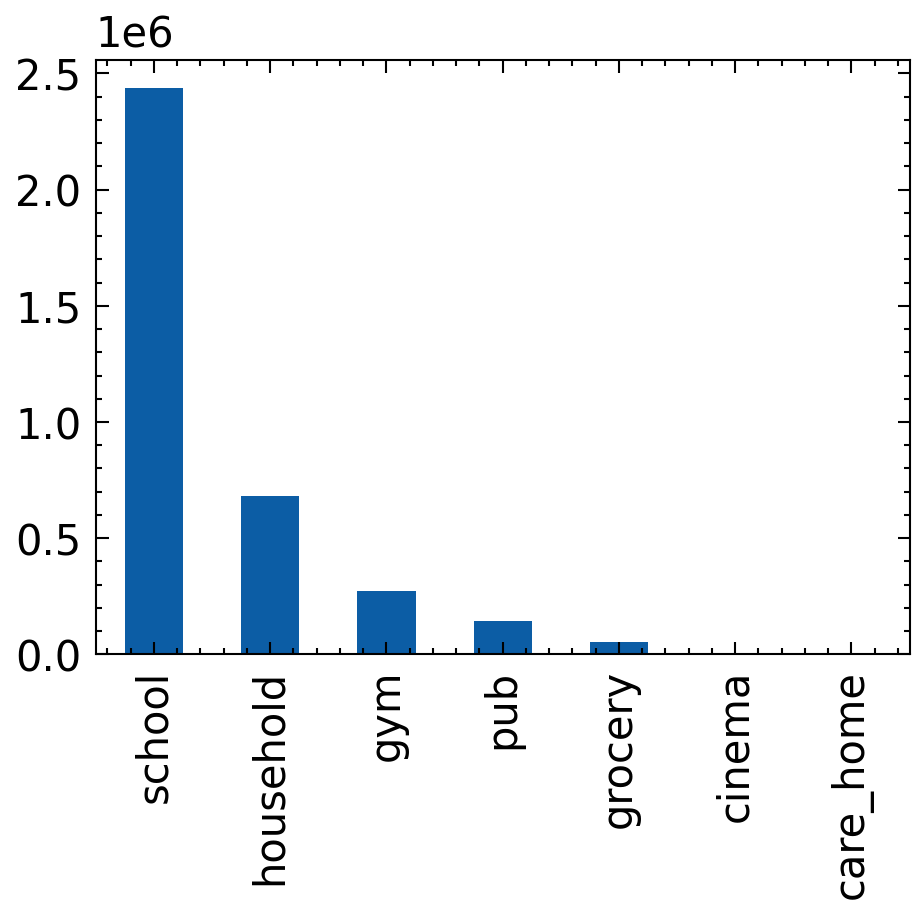

In [18]:
teen_infections_df['location_specs'].value_counts().plot.bar()

Text(0, 0.5, 'Infections in schools')

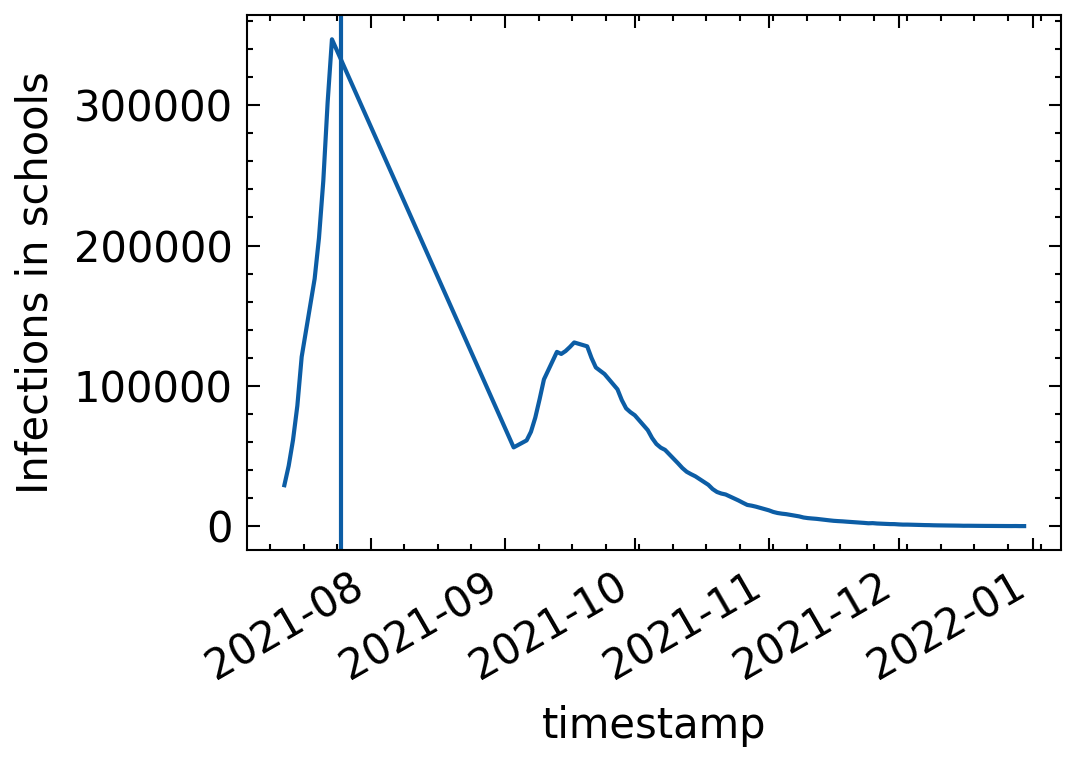

In [19]:
infections_df[infections_df['location_specs'] == 'school'].groupby('timestamp').size().plot()
plt.axvline(x='2021-07-25')
plt.ylabel('Infections in schools')